<div class="alert alert-block alert-info">
    <h1> POS tagging using modified Viterbi </h1>
</div>

### Data Preparation

In [1]:
#Importing libraries
import nltk
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pprint, time
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# samples: Each sentence is a list of (word, pos) tuples
nltk_data[:1]  #Check first Sentence

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')]]

### Splitting Dataset into 95:5

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print('Length of Training Set: ', len(train_set))
print('Length of Testing Set: ', len(test_set))


Length of Training Set:  3718
Length of Testing Set:  196


In [5]:
print(train_set[:5])   #Check samples of Train set

[[('One', 'NOUN'), ('claims', 'VERB'), ('0', 'X'), ('he', 'PRON'), ("'s", 'VERB'), ('pro-choice', 'ADJ'), ('.', '.')], [('Moreover', 'ADV'), (',', '.'), ('the', 'DET'), ('framers', 'NOUN'), ('believed', 'VERB'), ('that', 'ADP'), ('the', 'DET'), ('nation', 'NOUN'), ('needed', 'VERB'), ('a', 'DET'), ('unitary', 'ADJ'), ('executive', 'NOUN'), ('with', 'ADP'), ('the', 'DET'), ('independence', 'NOUN'), ('and', 'CONJ'), ('resources', 'NOUN'), ('0', 'X'), ('*', 'X'), ('to', 'PRT'), ('perform', 'VERB'), ('the', 'DET'), ('executive', 'NOUN'), ('functions', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('Confederation', 'NOUN'), ('Congress', 'NOUN'), ('had', 'VERB'), ('performed', 'VERB'), ('*T*-2', 'X'), ('poorly', 'ADV'), ('under', 'ADP'), ('the', 'DET'), ('Articles', 'NOUN'), ('of', 'ADP'), ('Confederation', 'NOUN'), ('*T*-1', 'X'), ('.', '.')], [('However', 'ADV'), (',', '.'), ('after', 'ADP'), ('two', 'NUM'), ('meetings', 'NOUN'), ('with', 'ADP'), ('the', 'DET'), ('Soviets', 'NOUN'), (',', '.')

In [6]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95684

In [7]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['One', 'claims', '0', 'he', "'s", 'pro-choice', '.', 'Moreover', ',', 'the']

In [8]:
# vocabulary
V = set(tokens)
print(len(V))

12075


In [9]:
# Check the number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [10]:
print (T)  #Print the tags

{'ADP', 'NUM', 'VERB', '.', 'PRON', 'ADV', 'X', 'DET', 'CONJ', 'ADJ', 'NOUN', 'PRT'}


In [11]:
#Check the count of POS Tags in train data set
from collections import Counter
tags = Counter([pair[1] for pair in train_tagged_words])
tags

Counter({'NOUN': 27484,
         'VERB': 12881,
         'X': 6290,
         'PRON': 2590,
         'ADJ': 6087,
         '.': 11151,
         'ADV': 3003,
         'DET': 8271,
         'ADP': 9381,
         'CONJ': 2150,
         'PRT': 3043,
         'NUM': 3353})

In [12]:
#Most Common tags in Train Data set
tags.most_common()

[('NOUN', 27484),
 ('VERB', 12881),
 ('.', 11151),
 ('ADP', 9381),
 ('DET', 8271),
 ('X', 6290),
 ('ADJ', 6087),
 ('NUM', 3353),
 ('PRT', 3043),
 ('ADV', 3003),
 ('PRON', 2590),
 ('CONJ', 2150)]

### Emission Probabilities

In [13]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [14]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [15]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [16]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [17]:
# convert the matrix to a dataframe for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [18]:
tags_df #Check the dataframe

,ADP,NUM,VERB,.,PRON,ADV,X,DET,CONJ,ADJ,NOUN,PRT
ADP,0.017269,0.062680,0.008208,0.039548,0.068649,0.013431,0.035071,0.323846,0.000853,0.106598,0.322354,0.001492
NUM,0.034596,0.185506,0.017894,0.117507,0.001491,0.002982,0.210259,0.003579,0.012824,0.034298,0.350731,0.028333
VERB,0.091685,0.022436,0.169242,0.035168,0.035401,0.081127,0.219082,0.133375,0.005357,0.064979,0.111016,0.031131
.,0.090934,0.080710,0.089050,0.092368,0.064748,0.052462,0.027621,0.173258,0.058649,0.044480,0.223298,0.002332
PRON,0.022394,0.007336,0.484170,0.040154,0.008108,0.033591,0.093436,0.010039,0.005019,0.075676,0.208108,0.011969
ADV,0.118548,0.031302,0.342657,0.137862,0.015318,0.079920,0.023976,0.069264,0.007326,0.127872,0.031635,0.014319
X,0.143084,0.002862,0.205087,0.163275,0.055644,0.025596,0.074563,0.054372,0.010652,0.017329,0.063752,0.183784
DET,0.009551,0.021884,0.039173,0.018015,0.003385,0.012937,0.045460,0.005562,0.000605,0.205537,0.637650,0.000242
CONJ,0.054419,0.041395,0.156279,0.034419,0.059535,0.055814,0.008372,0.117674,0.000465,0.118140,0.348837,0.004651
ADJ,0.077542,0.019878,0.012157,0.065878,0.000657,0.004600,0.020043,0.005093,0.016757,0.066535,0.700674,0.010186


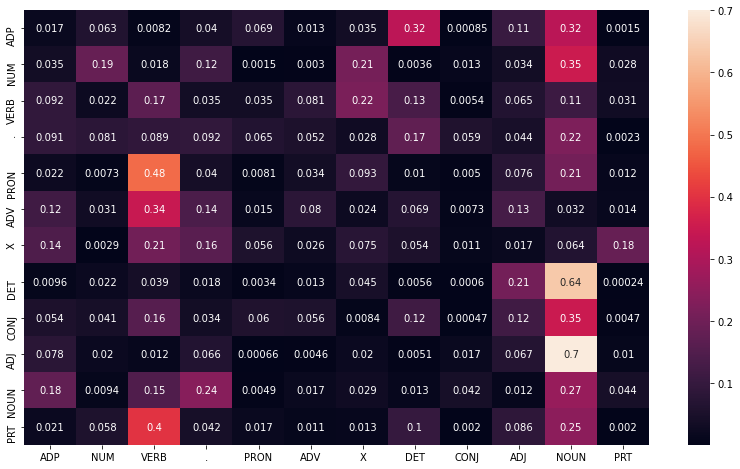

In [19]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

The heatmap shows the ADJECTIVE is followed by NOUN most of the times in training corpus. Also DET is followed by NOUN a lot. 

### Build the Vanilla Viterbi based POS tagger

In [20]:
# Vanilla Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Evaluating on Test Set

In [21]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# list of sents
test_run = test_set

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]


In [22]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [23]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  787.2420692443848
[('Interpublic', 'NOUN'), ('is', 'VERB'), ('providing', 'VERB'), ('the', 'DET'), ('programming', 'NOUN'), ('in', 'ADP'), ('return', 'NOUN'), ('for', 'ADP'), ('advertising', 'NOUN'), ('time', 'NOUN'), (',', '.'), ('which', 'DET'), ('it', 'PRON'), ('said', 'VERB'), ('0', 'X'), ('*T*-1', 'X'), ('will', 'VERB'), ('be', 'VERB'), ('valued', 'VERB'), ('*-85', 'X'), ('at', 'ADP'), ('more', 'ADJ'), ('than', 'ADP'), ('$', '.'), ('75', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('1990', 'NUM'), ('and', 'CONJ'), ('$', '.'), ('150', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('1991', 'NUM'), ('.', '.'), ('``', '.'), ('*', 'X'), ('Just', 'ADV'), ('to', 'PRT'), ('say', 'VERB'), ('0', 'X'), ('the', 'DET'), ('distribution', 'NOUN'), ('system', 'NOUN'), ('is', 'VERB'), ('wrong', 'ADJ'), ('does', 'VERB'), ("n't", 'ADV'), ('mean', 'VERB'), ('anything', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('a', 'DET'), ('M

In [24]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [25]:
vanilla_viterbi_accuracy = len(check)/len(tagged_seq)
vanilla_viterbi_accuracy

0.9060496794871795

In [26]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_words = [j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

In [27]:
print("Total Incorrect Tagged Words :", len(incorrect_tagged_words))

Total Incorrect Tagged Words : 469


In [28]:
incorrect_tagged_cases

[[('at', 'ADP'), (('more', 'ADJ'), ('more', 'ADV'))],
 [('*-1', 'X'), (('casting', 'ADP'), ('casting', 'VERB'))],
 [('solid', 'ADJ'), (('382-37', 'ADP'), ('382-37', 'NUM'))],
 [('kids', 'NOUN'), (('broke', 'ADP'), ('broke', 'VERB'))],
 [('also', 'ADV'), (('inherent', 'ADP'), ('inherent', 'ADJ'))],
 [("'s", 'PRT'),
  (('financial-services', 'NOUN'), ('financial-services', 'ADJ'))],
 [('set', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('``', '.'), (('Little', 'NOUN'), ('Little', 'ADV'))],
 [('by', 'ADP'), (('little', 'ADJ'), ('little', 'ADV'))],
 [('.', '.'), (('Steve', 'ADP'), ('Steve', 'NOUN'))],
 [('already', 'ADV'), (('laid', 'ADP'), ('laid', 'VERB'))],
 [('his', 'PRON'), (('claim', 'VERB'), ('claim', 'NOUN'))],
 [('$', '.'), (('93.9', 'ADP'), ('93.9', 'NUM'))],
 [('$', '.'), (('1.19', 'ADP'), ('1.19', 'NUM'))],
 [('$', '.'), (('92.9', 'ADP'), ('92.9', 'NUM'))],
 [('$', '.'), (('1.18', 'ADP'), ('1.18', 'NUM'))],
 [('year', 'NOUN'), (('earlier', 'ADV'), ('earlier', 'ADJ'))],
 [('to',

### Let's find Unknown Words in the Corpus

In [29]:
# Unknown words 

test_voc = set([t for t in test_tagged_words])

unknown_words = list(test_voc - T)
print("Total Unknown words :", len(unknown_words))
print("Unknown Words :", unknown_words)

Total Unknown words : 1855
Unknown Words : ['Cluff', 'U.S.-Japanese', 'net', '*T*-224', 'prices', 'Campbell', 'however', 'difficult', 'Hungary', 'eligible', 'Ford', 'percentage', 'Scotland', 'heating', 'receipts', 'which', 'Stoll', 'Foundation', 'annual', 'replicating', 'for', 'Ministry', 'quipped', 'printed', '-RRB-', 'career', 'name', 'highest', 'visit', 'December', 'evidence', 'newspapers', 'GHS', '1989', 'more', 'Grandsire', 'justices', 'fell', 'higher', 'specifics', '*-23', 'investor', 'tires', 'deny', 'still', 'vary', 'executing', 'Tache', 'of', 'May', 'representing', 'church', '*EXP*-2', 'Assuming', 'internal', 'judge', 'promotion', 'uses', 'again', 'Stock', 'start', 'is', 'stock-index', 'changes', 'indicator', 'Jones', 'cut', 'PS', 'dominating', 'Typically', 'DES', 'wary', 'avoid', '*ICH*-2', 'people', 'Caribbean', 'authors', '20', 'their', 'FBI', 'We', 'look', 'prospect', 'advertised', 'operate', 'into', '*T*-1', 'comparable', 'About', 'club', 'warned', 'convicted', 'Braidwood

### Let's try to add Rule Based (Regular Expression) tagger

Based on the incorrect tags identified from the Test Set, lets add a few Rule Based patterns to correct them

In [30]:
# defining patterns for tagging
patterns = [
    (r'^([0-9]|[a-zA-Z])+\-[a-zA-Z]*$','ADJ'),              # adjective
    (r'^[a-zA-Z]+(ing|ed|es)$', 'VERB'),               # Verb Suffix
    (r'.*ly$', 'ADV'),               #Adverbs
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),# cardinal numbers
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), #Determinants
    (r'.*', 'NOUN')                    # nouns
]

In [31]:
regexp_tagger = nltk.RegexpTagger(patterns)
# help(regexp_tagger)

In [32]:
regexp_accuracy =  regexp_tagger.evaluate(test_set)
print(regexp_accuracy)

0.41025641025641024


- We only get ~41% accuracy by using Regular Expression taggers

### Combining Taggers (Unigram with Rule Based)

In [33]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram backed up by the rule-based tagger
unigram_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

unigram_accuracy = unigram_tagger.evaluate(test_set)
print(unigram_accuracy)

0.9483173076923077


- Unigram tagger backed off by Rule Based Tagger gives ~94% accuracy

### Combining Taggers (Bigram, Unigram with Rule Based)

In [34]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram backed up by the rule-based tagger
unigram_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

# bigram backed up by the unigram tagger
bigram_tagger = nltk.BigramTagger(train_set, backoff=unigram_tagger)

bigram_accuracy = bigram_tagger.evaluate(test_set)
print(bigram_accuracy)

0.9545272435897436


- Combining Taggers with backoff gives an accuracy of ~95%

#### This proves that combining  Bigram tagger with Unigram and Rule-Based Approach can definitely increase the accuracy

### Solve the problem of unknown words

We will try to solve the problem of unknown words with below 2 approaches - 
- Viterbi Modification-Technique I: Modify the Viterbi Algorithm to solve Unknown words using Rule Based Approach
- Viterbi Modification-Technique II: Modify the Viterbi Algorithm to solve Unknown words by handling Emission Probability

### Viterbi Modification-Technique I

We will modify the Viterbi Algorithm to incorporte the rule based approach to handle unknown words

In [35]:
def Rule_Based_tagger (word, train_set = train_set):
    
    patterns = [
    (r'^([0-9]|[a-zA-Z])+\-[a-zA-Z]*$','ADJ'),              # adjective
    (r'^[a-zA-Z]+(able|ible|al|ful|ish|ive|less|ous)$', 'ADJ'),               # ADjective suffixes
    (r'^[a-zA-Z]+(ing|ed|es|ate|en|ify|ise|ize)$', 'VERB'),               # Verb Suffix
    (r'.*(ly|ward|wards|wise)$', 'ADV'),               #Adverbs  Suffix 
    (r'.*(er|or|hood|ment|ry|ship|ist|ness)$', 'NOUN'),              # possessive nouns
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),# cardinal numbers
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), #Determinants
    (r'.*', 'NOUN')                    # nouns
    ]

    rule_based_tagger = nltk.RegexpTagger(patterns)
    
    return rule_based_tagger.tag_sents([[(word)]])

In [36]:
# Modify viterbi algorithm to tag unknown words using regex patterns

def Viterbi_Rule_Based_Unknown_Tagger(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words logic
        if word not in V:
            unknown_wrd=Rule_Based_tagger(word) #Apply regex Rules to Unknown Words
            for sent in unknown_wrd:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [37]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_Rule_Based_Unknown_Tagger(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
viterbi_word_match_1 = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
viterbi_accuracy_1 = len(viterbi_word_match_1)/len(tagged_seq)
print('Modified Viterbi Technique 1 Accuracy: ', viterbi_accuracy_1)

Time taken in seconds:  739.6129229068756
Modified Viterbi Technique 1 Accuracy:  0.9535256410256411


#### Rule Based Approach helps to tag the unknown words in the test set and increase the accuracy by ~5% over Vanilla Viterbi Algorithm

In [38]:
#Check some Sample Test Case
## Testing with Vanilla Viterbi Algorithm
sentence_test = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'
#sentence_test_voc = set([t for t in sentence_test.split()])
words = word_tokenize(sentence_test)
start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start
print ('Time Taken :', difference)
print(tagged_seq)

Time Taken : 2.2526631355285645
[('NASA', 'ADP'), ('invited', 'ADP'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'ADP'), ('Satellite', 'ADP'), ('.', '.')]


In [39]:
## Testing with Modified Viterbi Algorithm
tagged_seq_modified = Viterbi_Rule_Based_Unknown_Tagger(words)
print(tagged_seq_modified)

[('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN'), ('.', '.')]


- __NASA,Satellite,ICESAT-2__ changed to NOUN correctly
- __invited__ changed to VERB correctly

### Viterbi Modification - Technique II 

As the Emission Probability will always be 0 for Unknown Words , we will modify the Viterbi Algorithm to assign Transition Probability to State Probability in such scenarios

In [40]:
# use transition probability of tags when emission probability is zero (in case of unknown words)

def Viterbi_Transition_Prob_Unknown_Word(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_trans =[] # storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_trans.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_trans)
            state_max = T[p_trans.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [41]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_Transition_Prob_Unknown_Word(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
viterbi_word_match_2 = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
viterbi_accuracy_2 = len(viterbi_word_match_2)/len(tagged_seq)
print('Modified Viterbi Technique 1 Accuracy: ', viterbi_accuracy_2)

Time taken in seconds:  802.7655119895935
Modified Viterbi Technique 1 Accuracy:  0.9372996794871795


#### The second approach to modify the Viterbi Algorithm to handle unknown words increases the accuracy by ~3%

In [42]:
#Check some Sample Test Case
## Testing with Vanilla Viterbi Algorithm
sentence_test = 'Before entering politics, Donald Trump was a domineering businessman and a television personality.'
#sentence_test_voc = set([t for t in sentence_test.split()])
words = word_tokenize(sentence_test)
start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start
print ('Time Taken :', difference)
print(tagged_seq)

Time Taken : 2.3268609046936035
[('Before', 'ADP'), ('entering', 'VERB'), ('politics', 'NOUN'), (',', '.'), ('Donald', 'NOUN'), ('Trump', 'NOUN'), ('was', 'VERB'), ('a', 'DET'), ('domineering', 'ADP'), ('businessman', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('television', 'NOUN'), ('personality', 'ADP'), ('.', '.')]


In [43]:
## Testing with Modified Viterbi Algorithm
tagged_seq_modified = Viterbi_Transition_Prob_Unknown_Word(words)
print(tagged_seq_modified)

[('Before', 'ADP'), ('entering', 'VERB'), ('politics', 'NOUN'), (',', '.'), ('Donald', 'NOUN'), ('Trump', 'NOUN'), ('was', 'VERB'), ('a', 'DET'), ('domineering', 'NOUN'), ('businessman', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('television', 'NOUN'), ('personality', 'NOUN'), ('.', '.')]


- __personality__ changed to NOUN

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [44]:
#Create dataframe with different Tagging Algorithm with their accuracies
compare_accur = pd.DataFrame([['Vanilla Viterbi', vanilla_viterbi_accuracy], 
                              ['Rule Based Tagger', regexp_accuracy], 
                              ['Unigram Tagger backed off by Rule Based', unigram_accuracy ],
                              ['Combined Tagger (Bigram, Unigram and Rule Based)', bigram_accuracy],
                              ['Modified Viterbi Algorithm - Technique I', viterbi_accuracy_1],
                              ['Modified Viterbi Algorithm - Technique II', viterbi_accuracy_2]]
                              , columns = ['Algorithm', 'Accuracy'])

In [45]:
compare_accur  # Compare the accuracies

,Algorithm,Accuracy
0,Vanilla Viterbi,0.906050
1,Rule Based Tagger,0.410256
2,Unigram Tagger backed off by Rule Based,0.948317
3,"Combined Tagger (Bigram, Unigram and Rule Based)",0.954527
4,Modified Viterbi Algorithm - Technique I,0.953526
5,Modified Viterbi Algorithm - Technique II,0.937300


<div class="alert alert-block alert-success">
<a id=section12></a> 
<h3>Modified Viterbi Algorithm - Technique I: Rule Based Taggers performs the best in terms of handling the Unknown Words </h3>
</div>

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [46]:
## Testing with Vanilla Viterbi Algorithm
sentence_test_1 = 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
#sentence_test_voc = set([t for t in sentence_test.split()])
words = word_tokenize(sentence_test_1)
start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start
print ('Time Taken :', difference)
print(tagged_seq)

Time Taken : 3.4643161296844482
[('The', 'DET'), ('2018', 'ADP'), ('FIFA', 'ADP'), ('World', 'NOUN'), ('Cup', 'ADP'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'ADP'), ('FIFA', 'ADP'), ('World', 'NOUN'), ('Cup', 'ADP'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'ADP'), ('contested', 'ADP'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


In [47]:
## Testing with Modified Viterbi Algorithm
tagged_seq_modified = Viterbi_Rule_Based_Unknown_Tagger(words)
print(tagged_seq_modified)

[('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


As you can see unknown words are tagged as "ADP" by Vanilla Viterbi Algorithm but the modified Viterbi Algorithm has converted those unknown words to right tags such as:
- Year "2018" changed to NUM correctly
- Words like "contested" changed to VERB correctly
- Words like "FIFA", "Cup" and "tournament" changed to NOUN correctly

In [48]:
## Testing with Vanilla Viterbi Algorithm
sentence_test_2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
#sentence_test_voc = set([t for t in sentence_test.split()])
words = word_tokenize(sentence_test_2)
start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start
print ('Time Taken :', difference)
print(tagged_seq)

Time Taken : 2.687094211578369
[('Android', 'ADP'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADP'), ('worldwide', 'ADP'), ('on', 'ADP'), ('smartphones', 'ADP'), ('since', 'ADP'), ('2011', 'ADP'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADP'), ('.', '.')]


In [49]:
## Testing with Modified Viterbi Algorithm
tagged_seq_modified = Viterbi_Rule_Based_Unknown_Tagger(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


As you can see unknown words are tagged as "ADP" by Vanilla Viterbi Algorithm but the modified Viterbi Algorithm has converted those unknown words to right tags such as:
- Years "2013" and "2011" changed to NUM
- Words like "Android" and "OS" changed to NOUN correctly

In [50]:
## Testing with Vanilla Viterbi Algorithm
sentence_test_3 = 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.'
#sentence_test_voc = set([t for t in sentence_test.split()])
words = word_tokenize(sentence_test_3)
start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start
print ('Time Taken :', difference)
print(tagged_seq)

Time Taken : 3.2339251041412354
[('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('price', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('flights', 'NOUN'), ('leaving', 'VERB'), ('Atlanta', 'NOUN'), ('at', 'ADP'), ('about', 'ADP'), ('3', 'NUM'), ('in', 'ADP'), ('the', 'DET'), ('afternoon', 'NOUN'), ('and', 'CONJ'), ('arriving', 'ADP'), ('in', 'ADP'), ('San', 'NOUN'), ('Francisco', 'NOUN'), ('.', '.')]


In [51]:
## Testing with Modified Viterbi Algorithm
tagged_seq_modified = Viterbi_Rule_Based_Unknown_Tagger(words)
print(tagged_seq_modified)

[('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('price', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('flights', 'NOUN'), ('leaving', 'VERB'), ('Atlanta', 'NOUN'), ('at', 'ADP'), ('about', 'ADP'), ('3', 'NUM'), ('in', 'ADP'), ('the', 'DET'), ('afternoon', 'NOUN'), ('and', 'CONJ'), ('arriving', 'VERB'), ('in', 'ADP'), ('San', 'NOUN'), ('Francisco', 'NOUN'), ('.', '.')]


As you can see unknown words are tagged as "ADP" by Vanilla Viterbi Algorithm but the modified Viterbi Algorithm has converted those unknown words to right tags such as:
- Words like "arriving" changed to VERB correctly